In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Preparing Features

In [51]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Loading DataFrame
df = pd.read_csv("processed_df/bet_event_df.csv")

# Pre-processing steps 
df = df.drop(['away_team_x', 'home_team_x', 'publishTime', 'sub_event_name', 'team_caused_event', 
              'event_name', 'winner', 'match_period', 'positions', 'tags', 'match_id_y', "player_id", 
              'team_id', 'date', 'match_name_x', 'home_team_id', 'away_team_id', 'marketId', 
              'selection_selectionId', 'selection_lastPriceTraded', 'match_name_y', 'team_name', 
              'home_team_y', 'away_team_y'], axis=1)
df = df.rename(columns={'match_id_x': 'match_id'})

# Split features and targets
x = df.drop(['home_winner', 'away_winner', 'draw_winner'], axis=1)
y = df[['match_id', 'home_winner', 'away_winner', 'draw_winner']]

# Group data by match_id
grouped_data = x.groupby('match_id')

scaled_sequences = []
match_ids = []

for match_id, group in grouped_data:
    # Cut-off time for the match (15 mins before the last recorded event)
    cut_off_time = group['event_sec'].max() - 900
    
    # Filter out data past the cut-off time
    group_filtered = group[group['event_sec'] <= cut_off_time]
    
    # Continue processing with the filtered group
    features_to_scale = group_filtered[['home_price', 'away_price', 'draw_price', 'ht_pos_pct', 'at_pos_pct']]
    features_to_skip = group_filtered[['ht_goals', 'at_goals', 'ht_red_cards', 'at_red_cards', 'ht_attack_intensity', 'at_attack_intensity',
                                       'ht_yellow_cards', 'at_yellow_cards', 'ht_other_fouls', 'at_other_fouls']]
    
    # Scale the selected features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_to_scale)
    
    # Concatenate back the unscaled features
    combined_features = np.concatenate([scaled_features, features_to_skip.to_numpy()], axis=1)
    
    scaled_sequences.append(combined_features)
    match_ids.append(match_id)

# Pad the sequences
X_padded = pad_sequences(scaled_sequences, padding='pre', dtype='float32')


### Preparing Labels

In [53]:
y_agg = y.groupby('match_id').agg({'home_winner': 'max', 'away_winner': 'max', 'draw_winner': 'max'}).reset_index()
y_encoded_ordered = np.array(y_agg.drop('match_id', axis = 1))

### Splitting Data into Train and Test set

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded_ordered, test_size=0.2, random_state=42)

### Keras Tuner

In [134]:
# Import necessary libraries
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(
        hp.Int('units', min_value=16, max_value=128, step=16),
        input_shape=(X_padded.shape[1], X_padded.shape[2]),
        return_sequences=False))
    model.add(layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(layers.Dense(
            hp.Int(f'dense_{i}_units', min_value=16, max_value=128, step=16),
            activation='tanh'))
        model.add(layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,  # Number of trials for searches
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='lstm_tuning')

# Display search space summary
tuner.search_space_summary()

# Perform the hyperparameter search
tuner.search(X_padded, y_encoded_ordered, epochs=10, validation_split=0.2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best number of units in the LSTM layer is {best_hps.get('units')} and the best dropout rate is {best_hps.get('dropout')}.
The optimal number of dense layers is {best_hps.get('num_layers')}, with their respective units and dropout rates as follows:""")

for i in range(best_hps.get('num_layers')):
    print(f"- Dense layer {i+1} units: {best_hps.get(f'dense_{i}_units')} with dropout: {best_hps.get('dropout')}")

print(f"The best learning rate for the optimizer is {best_hps.get('learning_rate')}.")


Trial 50 Complete [00h 00m 08s]
val_accuracy: 0.7777777910232544

Best val_accuracy So Far: 0.8055555820465088
Total elapsed time: 00h 06m 40s
INFO:tensorflow:Oracle triggered exit

The best number of units in the LSTM layer is 112 and the best dropout rate is 0.2.
The optimal number of dense layers is 2, with their respective units and dropout rates as follows:
- Dense layer 1 units: 32 with dropout: 0.2
- Dense layer 2 units: 96 with dropout: 0.2
The best learning rate for the optimizer is 0.00011307631534561521.


### Model Training

In [143]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

input_shape = (X_padded.shape[1], X_padded.shape[2])

model = Sequential()
model.add(LSTM(112, input_shape=input_shape, return_sequences=False)) 
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(96, activation='tanh'))
model.add(Dropout(0.2))
# Output layer with softmax activation for probability distribution among the 3 classes
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 112)               57344     
_________________________________________________________________
dropout_22 (Dropout)         (None, 112)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                3616      
_________________________________________________________________
dropout_23 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 96)                3168      
_________________________________________________________________
dropout_24 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 3)                

In [144]:
learning_rate = 0.00011307631534561521

model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_padded, y_encoded_ordered, epochs=10, batch_size=4, validation_split=0.2, verbose=1)

Epoch 1/10
36/36 [==============================] - 6s 108ms/step - loss: 0.9969 - accuracy: 0.4789 - val_loss: 0.8195 - val_accuracy: 0.7222
Epoch 2/10
36/36 [==============================] - 4s 102ms/step - loss: 0.8247 - accuracy: 0.7042 - val_loss: 0.7135 - val_accuracy: 0.7500
Epoch 3/10
36/36 [==============================] - 4s 99ms/step - loss: 0.7536 - accuracy: 0.7394 - val_loss: 0.6837 - val_accuracy: 0.7500
Epoch 4/10
36/36 [==============================] - 4s 101ms/step - loss: 0.6697 - accuracy: 0.7958 - val_loss: 0.6595 - val_accuracy: 0.7500
Epoch 5/10
36/36 [==============================] - 4s 98ms/step - loss: 0.6689 - accuracy: 0.7746 - val_loss: 0.6579 - val_accuracy: 0.7778
Epoch 6/10
36/36 [==============================] - 4s 100ms/step - loss: 0.6391 - accuracy: 0.7887 - val_loss: 0.6644 - val_accuracy: 0.7778
Epoch 7/10
36/36 [==============================] - 4s 101ms/step - loss: 0.5910 - accuracy: 0.7887 - val_loss: 0.6479 - val_accuracy: 0.7778
Epoch 8/

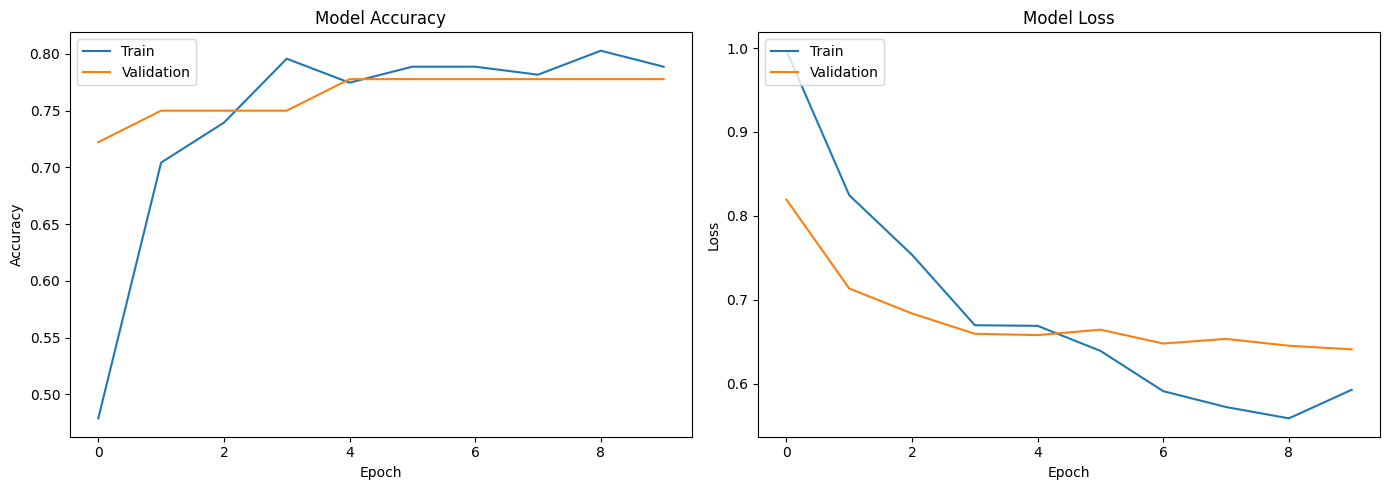

In [148]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('data_analysis/training_graph.png')
plt.show()

### Cross Validation

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

def create_model():
    model = Sequential()
    model.add(LSTM(112, input_shape=input_shape, return_sequences=False)) 
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(96, activation='tanh'))
    model.add(Dropout(0.2))
    # Output layer with softmax activation for probability distribution among the 3 classes
    model.add(Dense(3, activation='softmax'))
    
    # Learning rate
    learning_rate = 0.00011307631534561521

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model using KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=1, verbose=1)

# Perform cross-validation
scores = cross_val_score(model, X_padded, y_encoded_ordered, cv=5)

print("Accuracy: %.2f%% (%.2f%%)" % (scores.mean()*100, scores.std()*100))


Epoch 1/20
142/142 [==============================] - 15s 94ms/step - loss: 1.0186 - accuracy: 0.4789
Epoch 2/20
142/142 [==============================] - 14s 98ms/step - loss: 0.7948 - accuracy: 0.7535
Epoch 3/20
142/142 [==============================] - 13s 94ms/step - loss: 0.6883 - accuracy: 0.7606
Epoch 4/20
142/142 [==============================] - 13s 90ms/step - loss: 0.6052 - accuracy: 0.7887
Epoch 5/20
142/142 [==============================] - 13s 90ms/step - loss: 0.6239 - accuracy: 0.7887
Epoch 6/20
142/142 [==============================] - 12s 86ms/step - loss: 0.5744 - accuracy: 0.7887
Epoch 7/20
142/142 [==============================] - 12s 87ms/step - loss: 0.5876 - accuracy: 0.7958
Epoch 8/20
142/142 [==============================] - 13s 90ms/step - loss: 0.5586 - accuracy: 0.7746
Epoch 9/20
142/142 [==============================] - 13s 88ms/step - loss: 0.5196 - accuracy: 0.7817
Epoch 10/20
142/142 [==============================] - 13s 89ms/step - loss: 0.514

### Model Evaluation

Accuracy: 0.83
Precision: 0.86
Recall: 0.83
F1-Score: 0.83


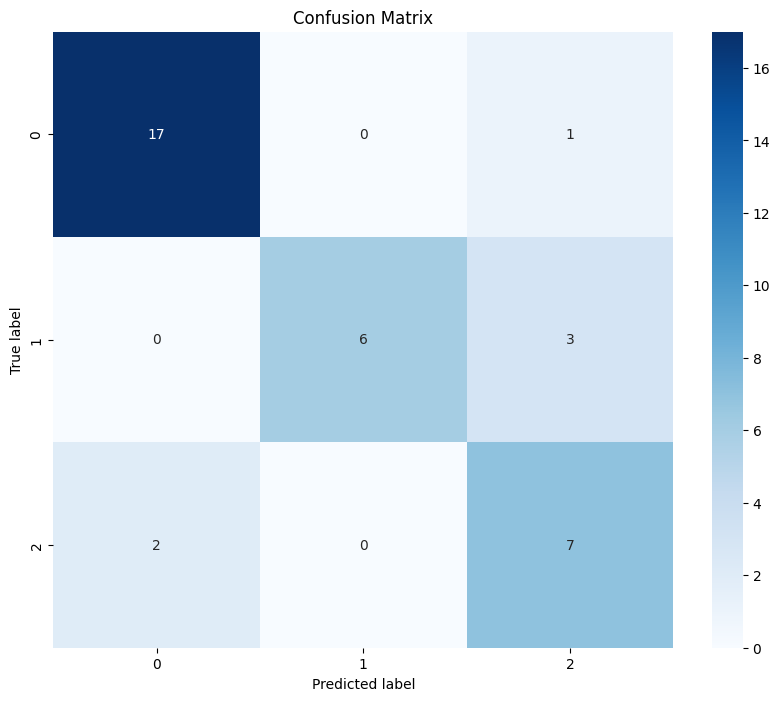

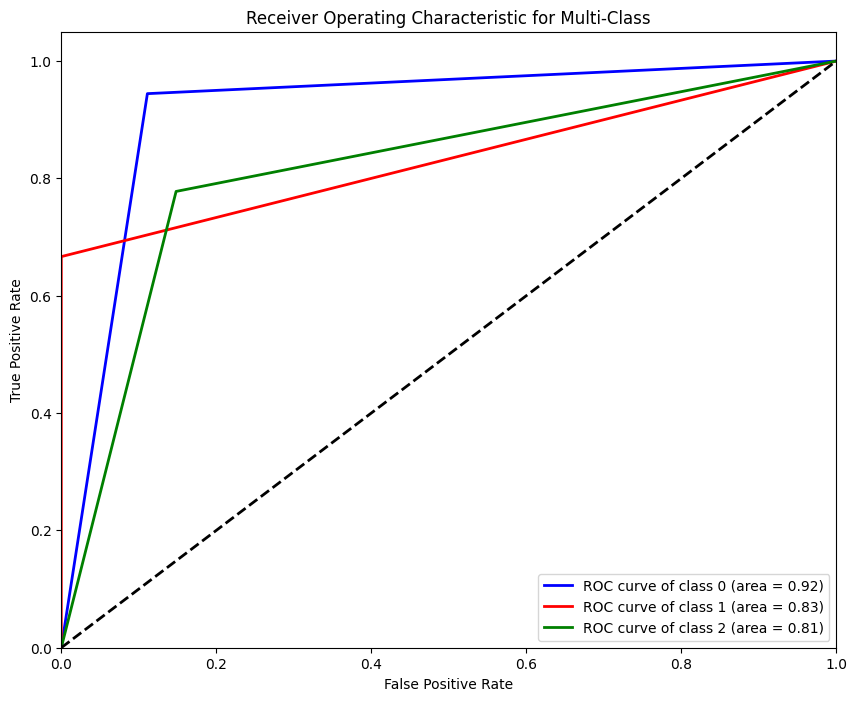

In [147]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_true = np.argmax(y_test, axis=1)
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Number of classes
n_classes = np.unique(y_true).shape[0]

# Binarize the output for ROC curve
y_test_binarized = label_binarize(y_true, classes=np.arange(n_classes))
y_pred_binarized = label_binarize(y_pred, classes=np.arange(n_classes))

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('data_analysis/confusion_matrix.png')
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.savefig('data_analysis/roc_curve.png')
plt.show()
